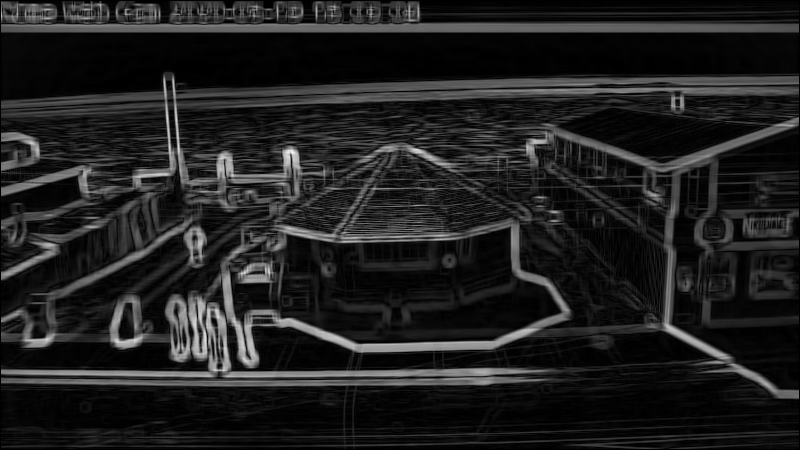

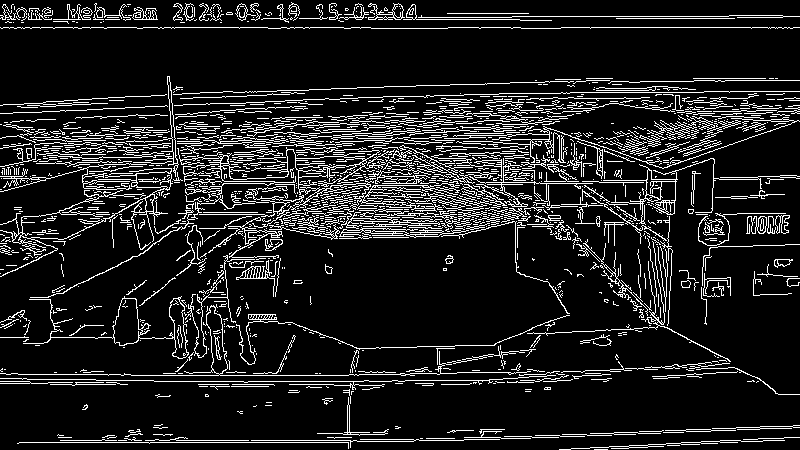

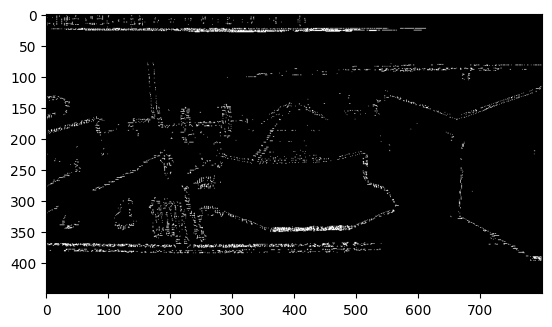

True

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def rgb2graysc(rgb):
    return 0.2126 * rgb[:,:,2] + 0.7152 * rgb[:,:,1] + 0.0722 * rgb[:,:,0]

def sobel_operator(image):
  horizontal = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], np.float32) #y-direction kernel for Sobel
  vertical = np.array([[1,2,1], [0,0,0], [-1,-2,-1]], np.float32) #x-direction kernel
  [rows,columns] = np.shape(image) #the shape of the grayscaled image

  #initialize array of zeros of the image shape for the x and y direction gradient approximation.
  gx = np.zeros((rows, columns), dtype=np.float32)
  gy = np.zeros((rows, columns), dtype=np.float32)


  #for loops to calculate the gradients in the x and y directions.
  for i in range(rows - 2):
    for j in range(columns - 2):
      gx[i+1,j+1] = np.sum(np.multiply(horizontal, image[i:i + 3, j:j + 3])) #x-direction gradient approximation image, we just take the sum of
      gy[i+1,j+1] = np.sum(np.multiply(vertical, image[i:i + 3, j:j + 3]))#y-direction gradient approximation image,

  #Compute magnitude using the square root of the sum of the two gradients squared.
  g_mag = np.hypot(gx,gy)
  #normalize output to values between 0 and 255 and convert to unsigned int 8 bit for future operations
  g_mag = ((255.0*g_mag) / g_mag.max()).astype(np.uint8)

  #caclcuate grad direction in degrees
  g_dir = (np.arctan2(gx, gy) / np.pi) * 180
  cv2_imshow(g_mag)
  return g_mag, g_dir

def non_max_suppression(mag, dir):
  #shape of image
  width, height = mag.shape

  #adjust negative angles to be positive
  dir[dir < 0] += 180

  #output array
  suppressed = np.zeros_like(mag)

  #Iterate through image to apply non_max suppression
  for i in range(1, width - 1):
    for j in range(1, height - 1):
      m = 255
      n = 255

      #check angle 0
      if (0 <= dir[i,j] < 22.5) or (157.5 <= dir[i,j] <= 180):
        m = mag[i, j + 1]
        n = mag[i, j - 1]

      #check angle 45
      elif (22.5 <= dir[i,j] < 67.5):
        m = mag[i + 1, j - 1]
        n = mag[i - 1, j + 1]

      #check angle 90
      elif (67.5 <= dir[i, j] < 112.5):
        m = mag[i + 1, j]
        n = mag[i - 1, j]

      #check angle 135
      elif (112.5 <= dir[i, j] < 157.5):
        m = mag[i - 1, j - 1]
        n = mag[i + 1, j + 1]

      #apply non_max
      if (mag[i, j] >= m) and (mag[i, j] >= n):
        suppressed[i, j] = mag[i, j]
      else:
        suppressed[i, j] = 0


  return suppressed

def double_thresh(img, upper, lower):
  #initialize variables for thresholding
  width, height = img.shape
  high_thresh = image.max() * upper
  low_thresh = image.max() * lower
  strong_pixel = 255.0
  weak_pixel = 100

  #output matrix
  output = np.zeros((width, height), dtype=np.int32)

  #find strong edges
  s_i, s_j = np.where(img >= high_thresh)

  #find weak edges
  w_i, w_j = np.where((img >= low_thresh) & (img <= high_thresh))

  #set strong pixels to strong edges
  output[s_i, s_j] = strong_pixel

  #set weak pixels to weak edges
  output[w_i,w_j] = weak_pixel


  return output


#function for hysteresis
def hysteresis(img):
    #Image shape
    width, height = img.shape

    #Initialize output
    output = np.copy(img)

    #Pixel values to represent strong and weak edge pixels for hysteresis
    strong_pixel = 255.0
    weak_pixel = 100

    #Iterate through image to apply hysteresis
    for i in range(1, width-1):
        for j in range(1, height-1):
            if (img[i, j] == weak_pixel): # if weak edge detected apply hysteresis
                if (img[i+1, j-1] == strong_pixel) or (img[i+1, j] == strong_pixel) or (img[i+1, j+1] == strong_pixel) or (img[i, j-1] == strong_pixel) or (img[i, j+1] == strong_pixel) or (img[i-1, j-1] == strong_pixel) or (img[i-1, j] == strong_pixel) or (img[i-1, j+1] == strong_pixel):
                    # if surrounded by strong pixels, then set to strong value
                    output[i, j] = strong_pixel
                else:
                    # otherwise set to 0
                    output[i, j] = 0
    return output


#read image
image = cv2.imread('Intersec.jpg')

#convert to array
im_arr = np.array(image)

#grayscale
gray_im = rgb2graysc(im_arr)

#Apply Gaussian Blur
#Change the sigma value and kernel size to manipulate results
blur_im = cv2.GaussianBlur(gray_im, (9,9), 9)

#apply Sobel Operator
grad_mag, grad_dir = sobel_operator(blur_im)

#apply non_max suppression
supp_img = non_max_suppression(grad_mag, grad_dir)

#apply thresholding
#We can manipulate the thresholds to change the accuracy of the edges detected
thresh_img = double_thresh(supp_img, 0.2, 0.7)

#apply hysteresis
Canny_img = hysteresis(thresh_img)

#CV2 canny detected image for comparision
CV_canny = cv2.Canny(image, 100, 200)
cv2_imshow(CV_canny)

plt.imshow(Canny_img, cmap = plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()
#Display Img
cv2.imwrite('Canny detection img.png', Canny_img.astype(np.uint8))
